In [1]:
import numpy as np

class Point:
    """A point located at (x,y) in 2D space.

    Each Point object may be associated with a payload object.

    """

    def __init__(self, x, y, payload=None):
        self.x, self.y = x, y
        self.payload = payload

    def __repr__(self):
        return '{}: {}'.format(str((self.x, self.y)), repr(self.payload))
    def __str__(self):
        return 'P({:.2f}, {:.2f})'.format(self.x, self.y)

    def distance_to(self, other):
        try:
            other_x, other_y = other.x, other.y
        except AttributeError:
            other_x, other_y = other
        return np.hypot(self.x - other_x, self.y - other_y)

class Rect:
    """A rectangle centred at (cx, cy) with width w and height h."""

    def __init__(self, cx, cy, w, h):
        self.cx, self.cy = cx, cy
        self.w, self.h = w, h
        self.west_edge, self.east_edge = cx - w/2, cx + w/2
        self.north_edge, self.south_edge = cy - h/2, cy + h/2

    def __repr__(self):
        return str((self.west_edge, self.east_edge, self.north_edge,
                self.south_edge))

    def __str__(self):
        return '({:.2f}, {:.2f}, {:.2f}, {:.2f})'.format(self.west_edge,
                    self.north_edge, self.east_edge, self.south_edge)

    def contains(self, point):
        """Is point (a Point object or (x,y) tuple) inside this Rect?"""

        try:
            point_x, point_y = point.x, point.y
        except AttributeError:
            point_x, point_y = point

        return (point_x >= self.west_edge and
                point_x <  self.east_edge and
                point_y >= self.north_edge and
                point_y < self.south_edge)

    def intersects(self, other):
        """Does Rect object other interesect this Rect?"""
        return not (other.west_edge > self.east_edge or
                    other.east_edge < self.west_edge or
                    other.north_edge > self.south_edge or
                    other.south_edge < self.north_edge)

    def draw(self, ax, c='k', lw=1, **kwargs):
        x1, y1 = self.west_edge, self.north_edge
        x2, y2 = self.east_edge, self.south_edge
        ax.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1], c=c, lw=lw, **kwargs)


class QuadTree:
    """A class implementing a quadtree."""

    def __init__(self, boundary, max_points=4, depth=0):
        """Initialize this node of the quadtree.

        boundary is a Rect object defining the region from which points are
        placed into this node; max_points is the maximum number of points the
        node can hold before it must divide (branch into four more nodes);
        depth keeps track of how deep into the quadtree this node lies.

        """

        self.boundary = boundary
        self.max_points = max_points
        self.points = []
        self.depth = depth
        # A flag to indicate whether this node has divided (branched) or not.
        self.divided = False

    def __str__(self):
        """Return a string representation of this node, suitably formatted."""
        sp = ' ' * self.depth * 2
        s = str(self.boundary) + '\n'
        s += sp + ', '.join(str(point) for point in self.points)
        if not self.divided:
            return s
        return s + '\n' + '\n'.join([
                sp + 'nw: ' + str(self.nw), sp + 'ne: ' + str(self.ne),
                sp + 'se: ' + str(self.se), sp + 'sw: ' + str(self.sw)])

    def divide(self):
        """Divide (branch) this node by spawning four children nodes."""

        cx, cy = self.boundary.cx, self.boundary.cy
        w, h = self.boundary.w / 2, self.boundary.h / 2
        # The boundaries of the four children nodes are "northwest",
        # "northeast", "southeast" and "southwest" quadrants within the
        # boundary of the current node.
        self.nw = QuadTree(Rect(cx - w/2, cy - h/2, w, h),
                                    self.max_points, self.depth + 1)
        self.ne = QuadTree(Rect(cx + w/2, cy - h/2, w, h),
                                    self.max_points, self.depth + 1)
        self.se = QuadTree(Rect(cx + w/2, cy + h/2, w, h),
                                    self.max_points, self.depth + 1)
        self.sw = QuadTree(Rect(cx - w/2, cy + h/2, w, h),
                                    self.max_points, self.depth + 1)
        self.divided = True

    def insert(self, point):
        """Try to insert Point point into this QuadTree."""

        if not self.boundary.contains(point):
            # The point does not lie inside boundary: bail.
            return False
        if len(self.points) < self.max_points:
            # There's room for our point without dividing the QuadTree.
            self.points.append(point)
            return True

        # No room: divide if necessary, then try the sub-quads.
        if not self.divided:
            self.divide()

        return (self.ne.insert(point) or
                self.nw.insert(point) or
                self.se.insert(point) or
                self.sw.insert(point))

    def query(self, boundary, found_points):
        """Find the points in the quadtree that lie within boundary."""

        if not self.boundary.intersects(boundary):
            # If the domain of this node does not intersect the search
            # region, we don't need to look in it for points.
            return False

        # Search this node's points to see if they lie within boundary ...
        for point in self.points:
            if boundary.contains(point):
                found_points.append(point)
        # ... and if this node has children, search them too.
        if self.divided:
            self.nw.query(boundary, found_points)
            self.ne.query(boundary, found_points)
            self.se.query(boundary, found_points)
            self.sw.query(boundary, found_points)
        return found_points


    def query_circle(self, boundary, centre, radius, found_points):
        """Find the points in the quadtree that lie within radius of centre.

        boundary is a Rect object (a square) that bounds the search circle.
        There is no need to call this method directly: use query_radius.

        """

        if not self.boundary.intersects(boundary):
            # If the domain of this node does not intersect the search
            # region, we don't need to look in it for points.
            return False

        # Search this node's points to see if they lie within boundary
        # and also lie within a circle of given radius around the centre point.
        for point in self.points:
            if (boundary.contains(point) and
                    point.distance_to(centre) <= radius):
                found_points.append(point)

        # Recurse the search into this node's children.
        if self.divided:
            self.nw.query_circle(boundary, centre, radius, found_points)
            self.ne.query_circle(boundary, centre, radius, found_points)
            self.se.query_circle(boundary, centre, radius, found_points)
            self.sw.query_circle(boundary, centre, radius, found_points)
        return found_points

    def query_radius(self, centre, radius, found_points):
        """Find the points in the quadtree that lie within radius of centre."""

        # First find the square that bounds the search circle as a Rect object.
        boundary = Rect(*centre, 2*radius, 2*radius)
        return self.query_circle(boundary, centre, radius, found_points)


    def __len__(self):
        """Return the number of points in the quadtree."""

        npoints = len(self.points)
        if self.divided:
            npoints += len(self.nw)+len(self.ne)+len(self.se)+len(self.sw)
        return npoints

    def draw(self, ax):
        """Draw a representation of the quadtree on Matplotlib Axes ax."""

        self.boundary.draw(ax)
        if self.divided:
            self.nw.draw(ax)
            self.ne.draw(ax)
            self.se.draw(ax)
            self.sw.draw(ax)

Number of points in the domain = 429
Number of found points = 51


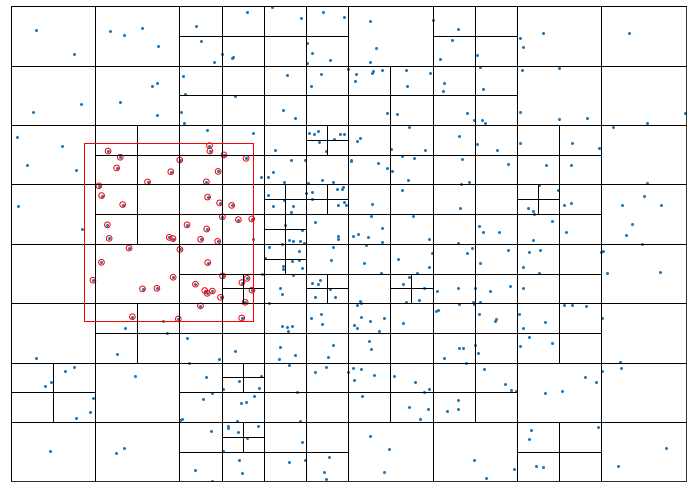

In [3]:
import numpy as np
import matplotlib.pyplot as plt
# from quadtree import Point, Rect, QuadTree
from matplotlib import gridspec

DPI = 72
np.random.seed(60)

width, height = 600, 400

N = 500
coords = np.random.randn(N, 2) * height/3 + (width/2, height/2)
points = [Point(*coord) for coord in coords]

domain = Rect(width/2, height/2, width, height)
qtree = QuadTree(domain, 3)
for point in points:
    qtree.insert(point)

print('Number of points in the domain =', len(qtree))

fig = plt.figure(figsize=(700/DPI, 500/DPI), dpi=DPI)
ax = plt.subplot()
ax.set_xlim(0, width)
ax.set_ylim(0, height)
qtree.draw(ax)

ax.scatter([p.x for p in points], [p.y for p in points], s=4)
ax.set_xticks([])
ax.set_yticks([])

region = Rect(140, 190, 150, 150)
found_points = []
qtree.query(region, found_points)
print('Number of found points =', len(found_points))

ax.scatter([p.x for p in found_points], [p.y for p in found_points],
           facecolors='none', edgecolors='r', s=32)

region.draw(ax, c='r')

ax.invert_yaxis()
plt.tight_layout()
# plt.savefig('search-quadtree.png', DPI=72)
plt.show()